In [153]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import style

In [154]:
#Puts dataset into dataframe, Change filepath depending on where it is in your computer
diabetes = pd.read_csv("data/diabetic_data.csv")
#Split data into target class Y, and data attributes X
X = diabetes.loc[:,'race':'diabetesMed']
Y = diabetes['readmitted']
#Split the into nominal and numerical attributes
num = diabetes.select_dtypes(include = 'int').iloc[:,1:]
cat = diabetes.select_dtypes(include = 'object')
print('Data Shape: ', diabetes.shape)
print('Data Columns: ', diabetes.columns.values)

Data Shape:  (101766, 50)
Data Columns:  ['encounter_id' 'patient_nbr' 'race' 'gender' 'age' 'weight'
 'admission_type_id' 'discharge_disposition_id' 'admission_source_id'
 'time_in_hospital' 'payer_code' 'medical_specialty' 'num_lab_procedures'
 'num_procedures' 'num_medications' 'number_outpatient' 'number_emergency'
 'number_inpatient' 'diag_1' 'diag_2' 'diag_3' 'number_diagnoses'
 'max_glu_serum' 'A1Cresult' 'metformin' 'repaglinide' 'nateglinide'
 'chlorpropamide' 'glimepiride' 'acetohexamide' 'glipizide' 'glyburide'
 'tolbutamide' 'pioglitazone' 'rosiglitazone' 'acarbose' 'miglitol'
 'troglitazone' 'tolazamide' 'examide' 'citoglipton' 'insulin'
 'glyburide-metformin' 'glipizide-metformin' 'glimepiride-pioglitazone'
 'metformin-rosiglitazone' 'metformin-pioglitazone' 'change' 'diabetesMed'
 'readmitted']


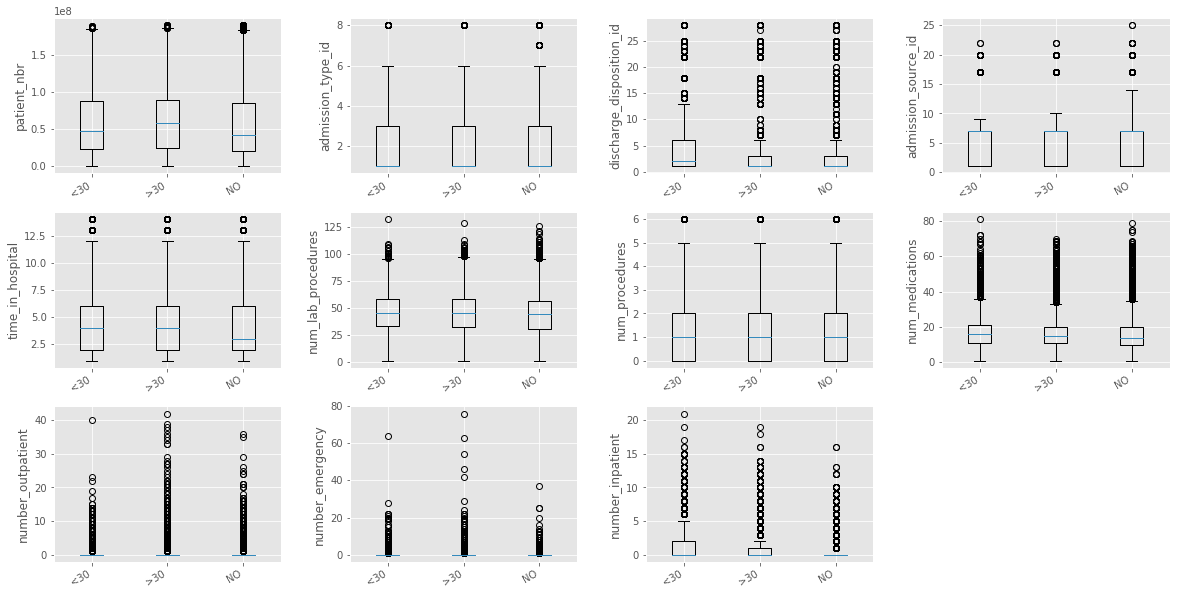

In [155]:
##This code plots the correlation between the numerical data and target class data
#Splits the numerical data bsed on which class it is in
l30 = num.loc[diabetes['readmitted'] == '<30']
g30 = num.loc[diabetes['readmitted'] == '>30']
no = num.loc[diabetes['readmitted'] == 'NO']
#plots it using a ggplot
plt.style.use('ggplot')
fig, axs = plt.subplots(3, 4, figsize=(20,10))
for i in range(1,12):
    plt.subplot(3,4,i)
    plt.boxplot([l30[num.columns.values[i-1]],g30[num.columns.values[i-1]],no[num.columns.values[i-1]]])
    plt.xticks([1,2,3], ['<30','>30','NO'], rotation = 30, ha = 'right')
    plt.ylabel(num.columns.values[i-1])
plt.subplots_adjust(wspace=0.30, hspace = 0.25)
fig.delaxes(axs[2][3])
plt.show()

readmitted
<30    11357
>30    35545
NO     54864
dtype: int64


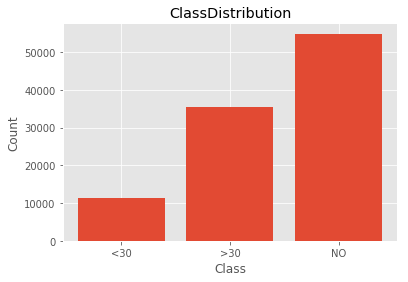

In [156]:
##This checks class distribution
resultGroup = diabetes.groupby('readmitted').size()
print(resultGroup)
plt.bar(['<30','>30','NO'], resultGroup)
plt.title('ClassDistribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

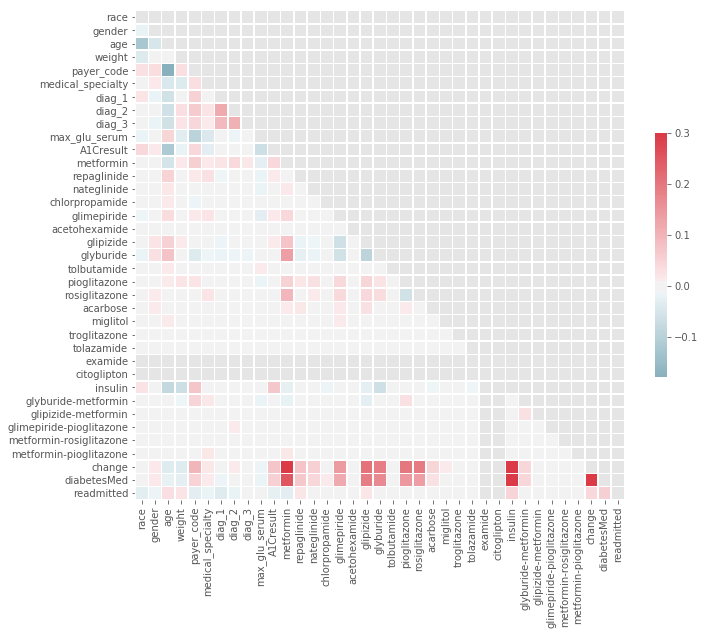

In [157]:
##This plots the correlation between all the categorical data, look at the bottom row to see all the 
##correlation with the target class the positive num means positive correlation, 0 mean no correaltion
## and negative means no correlation
#Calculate the corelation matrix
df = cat
corr = df.apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1)
#Plot correlation matrix on a heat map
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [158]:
##Takes the nomimal target class and converts it to binarized vectors so you can use sklearn libraries
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
lb.fit(Y)
binarized_Y = lb.transform(Y)

In [159]:
##This takes the nomnial data and converts it to binarized data using onehotencode
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
encoded = []
cat_arr = cat.values
for i in range (cat_arr.shape[1]):
    le = LabelEncoder()
    le.fit(cat_arr[:,i])
    encoded.append(le.transform(cat_arr[:,i]))
encoded_np = np.transpose(np.array(encoded))
one = OneHotEncoder()
one.fit(encoded_np)
onehotX = one.transform(encoded_np).toarray()
#append numerical data so that you can have one dataset
num_arr = num.values
for i in range (num_arr.shape[1]):
    np.append(onehotX, num_arr[:,i])

In [160]:
##I just used 4 classifiers to check if it works. It seems to work fine. You can add more if you'd like
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

In [161]:
##For all the classifiers you can choose how you want to split the data into test and training data
##I just used the first 1000 records to train and I tested them on the second 1000 records
knn1 = KNeighborsClassifier(1)
knn1.fit(onehotX[0:999], binarized_Y[0:999])
kprediction = knn1.predict(onehotX[1000:1999])

In [162]:
dtc = DecisionTreeClassifier()
dtc.fit(onehotX[0:999], binarized_Y[0:999])
dprediction = dtc.predict(onehotX[1000:1999])

In [163]:
rfc = RandomForestClassifier(n_estimators=100,random_state=0)
rfc.fit(onehotX[0:999], binarized_Y[0:999])
rprediction = rfc.predict(onehotX[1000:1999])

In [164]:
mlp = MLPClassifier()
mlp.fit(onehotX[0:999], binarized_Y[0:999])
mprediction = mlp.predict(onehotX[1000:1999])

In [165]:
##I used this to check the accuracy of each. I compared the prediction to the actual class and did some math.
accuracy = [0,0,0,0]
for i in range (999):
    if(binarized_Y[i+1000] == kprediction[i]).all():
        accuracy[1] = accuracy[0] + 1
    if(binarized_Y[i+1000] == dprediction[i]).all():
        accuracy[2] = accuracy[1] + 1
    if(binarized_Y[i+1000] == rprediction[i]).all():
        accuracy[3] = accuracy[2] + 1
    if(binarized_Y[i+1000] == mprediction[i]).all():
        accuracy[4] = accuracy[3] + 1
        
print('1-NN Accuracy: ', accuracy[0]/len(kprediction)* 100,'%')
print('DTC Accuracy: ',accuracy[1]/len(dprediction) * 100,'%')  
print('RFC Accuracy: ',accuracy[2]/len(rprediction) * 100,'%')  
print('MLP Accuracy: ',accuracy[3]/len(mprediction) * 100,'%')

IndexError: list assignment index out of range